In [1]:
# Import necessary libraries
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Christina Yap Xin Yi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the saved model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./saved_model_distilbert')
tokenizer = DistilBertTokenizerFast.from_pretrained('./saved_model_distilbert')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [3]:
# Load test dataset CSV
test_df = pd.read_csv('../../../data/test_data.csv')

# Map labels
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
test_df['label'] = test_df['Analysis'].map(label_mapping)
test_df['text'] = test_df['text'].astype(str).fillna("")

# Convert to HuggingFace Dataset
test_dataset = Dataset.from_pandas(test_df)

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set torch format
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 1938/1938 [00:00<00:00, 7911.97 examples/s]


In [4]:
# DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [14]:
# Generate Classification Report as Dictionary
report_dict = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# Convert to Pandas DataFrame for Pretty Table
report_df = pd.DataFrame(report_dict).transpose()

# Display Only Class-wise Metrics
class_metrics_df = report_df.loc[['Negative', 'Neutral', 'Positive'], ['precision', 'recall', 'f1-score', 'support']]

# Save Class-wise Metrics to CSV
class_metrics_df.to_csv("classification_metrics_per_class.csv", index=True)

print("Metrics table saved as 'classification_metrics_per_class.csv'")

Metrics table saved as 'classification_metrics_per_class.csv'


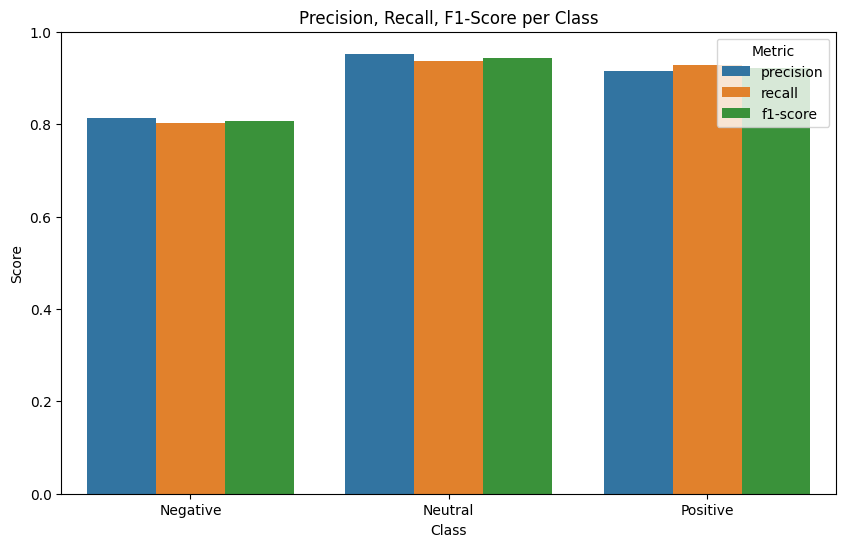

In [15]:
# Reset index to use 'Class' as a column
class_metrics_df = class_metrics_df.reset_index().rename(columns={'index': 'Class'})

# Melt DataFrame for seaborn plotting
melted_df = class_metrics_df.melt(id_vars='Class', value_vars=['precision', 'recall', 'f1-score'], var_name='Metric', value_name='Score')

# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=melted_df, x='Class', y='Score', hue='Metric')
plt.title('Precision, Recall, F1-Score per Class')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.savefig("classification_barchart_distilbert.png")
plt.show()

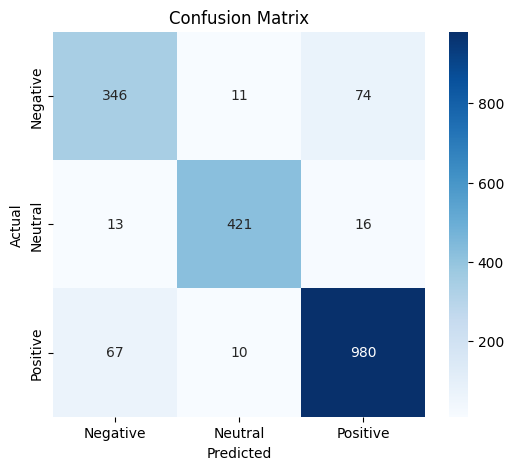

In [7]:
# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix_distilbert.png")
plt.show()


In [8]:
# Reverse mapping numeric labels to class names
reverse_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_labels = [reverse_mapping[pred] for pred in all_preds]

# Add predictions to DataFrame
test_df['Predicted'] = predicted_labels

# Save to CSV
test_df.to_csv('test_predictions_distilbert.csv', index=False)

print("Predictions exported to test_predictions_distilbert.csv")


Predictions exported to test_predictions_distilbert.csv
